# Revenue Maximization Task

## Objective:
A core part of Credit business model si upgrading existing customers whti value-add products and services. This can occur ni two ways: either as an upsellincreasing the daily rate ot a customer currently in-payment) or as an upgrade(adding additional days onto aloan that has already been completed).
The number of upgrade and upsell loans we're able to sel are dependent on anumber of factors; the size of the active customer base, eligibility, including both credit performance (we only sell these loans to customers with a good repayment history) and timing (customers are only eligible at certain points ni their lifecycle) and the conversion rate (what %of eligible customers decide to purchase an additional loan).
In order to maximize profitability and properly forecast inventory requirements, we have to undertake 2 important (and related) exercises: determining the business rules that govern what product we sell and when, and, out of this, forecast units sold by month.

## The Exercise:
In this exercise, you will determine the mix of cash loans (an upsell loan) and Product upgrades (an upgrade loan) we'll sell to Current customers ni 2023 ni order to maximize upgrade +upsell profitability (Classics Assets Products are the core Mobile Phone, Tablet, Decoder, Radio, phone-charging product).

Dummy sales data through 2023 is available at Data/data.csv. Afew simplifying assumptions:
* Aloan that is eligible for an upgrade wil take 400 days from purchase to date of finished payment, assuming no upsell loans
* Each upsell loan lasts for 150 days and extends the date of finished payment of the underlying loan by 50 days
* TV upgrade loans aren't eligible for upsell loans
* Loans that have finished payment aren't eligible for cash loans
* TV upgrade loans must be purchased the day the Classic loan is finished (e.g. can't sell to 'old' finished payment customers)
* 90% of customers are eligible for a cash loan
* Neither cash loans nor TV upgrades have any limitations on the maximum or minimum volumes
* %57 of customers who haven't purchased any upsel olans are eligible for aVT upgrade, htsi number decreases by 02 percentage points for each cash loan they ve purchased
* 90% of customers ofered a cash olan wli purchase, %05 fo customers ofered a TV upgrade wil purchase
* Cash olans yield aprofit fo$25; TV upgrades yield a porfit fo $150 (accounted for on day of sale)
* Use an annual discount rate of %51 • Ignore any impact post-2023

### Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import numpy as np
from pulp import LpMaximize, LpProblem, LpVariable, lpSum

### Data loading

In [7]:
file_path = 'Data/data.csv'
df = pd.read_csv(file_path)

df.head()

,Month,Volume (units)
0,1/31/19,10000
1,2/28/19,"10,200"
2,3/31/19,"10,404"
3,4/30/19,"10,612"
4,5/31/19,"10,824"


### Data Exploration

In [9]:
# Checking the data types for each column
print(df.dtypes)

Month             object
Volume (units)    object
dtype: object


In [10]:
# Checking for the missing values
print(df.isnull().sum())

Month             0
Volume (units)    0
dtype: int64


In [11]:
# checking for data duplicates
print(df.duplicated().sum())

0


In [12]:
# checking for data desc
print(df.describe())

          Month Volume (units)
count        60             60
unique       60             60
top     1/31/19          10000
freq          1              1


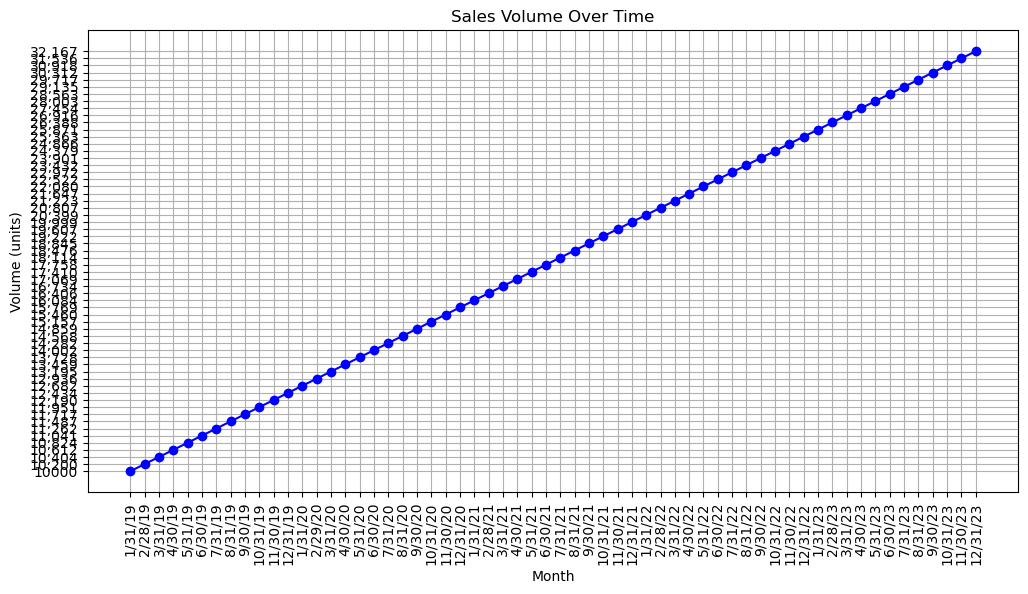

In [13]:
# Exploring the distribution of sales volume over time
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Volume (units)'], marker='o', color='b')
plt.title('Sales Volume Over Time')
plt.xlabel('Month')
plt.ylabel('Volume (units)')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

### Data Pre-Processing

In [15]:
# Removing commas from the 'Volume (units)' column values
df['Volume (units)'] = df['Volume (units)'].str.replace(',', '')

# Converting 'Month' column to datetime datatype
df['Month'] = pd.to_datetime(df['Month'], format='%m/%d/%y')

# Converting 'Volume (units)' column to numeric datatype
df['Volume (units)'] = pd.to_numeric(df['Volume (units)'])

# Checking the updated data types
print(df.dtypes)

Month             datetime64[ns]
Volume (units)             int64
dtype: object


In [16]:
# checking the updated df
df.head()

,Month,Volume (units)
0,2019-01-31,10000
1,2019-02-28,10200
2,2019-03-31,10404
3,2019-04-30,10612
4,2019-05-31,10824


### Exploratory Data Analysis

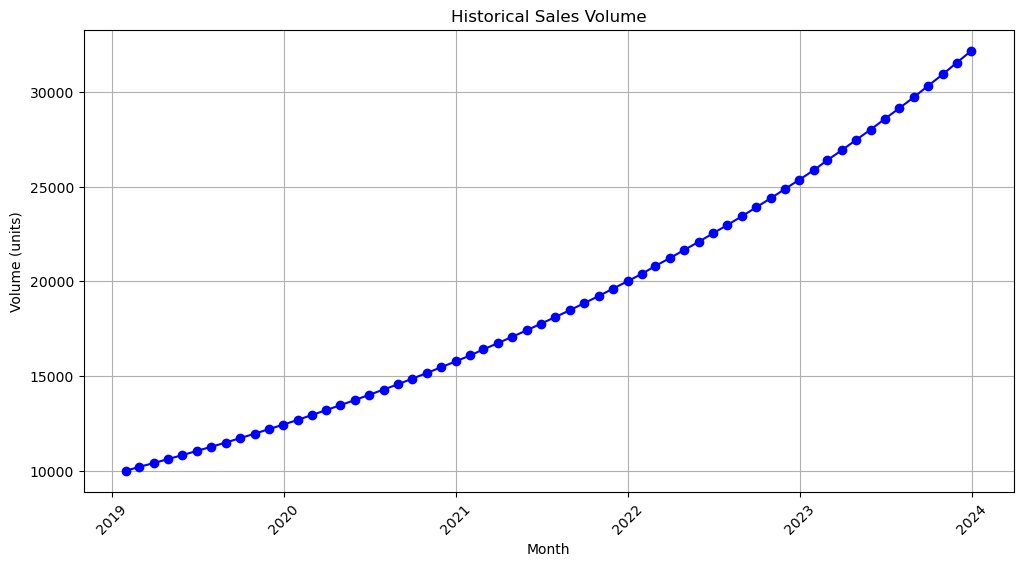

<Figure size 640x480 with 0 Axes>

In [89]:
# Plot the historical sales data
plt.figure(figsize=(12, 6))
plt.plot(df['Month'], df['Volume (units)'], marker='o', color='b')
plt.title('Historical Sales Volume')
plt.xlabel('Month')
plt.ylabel('Volume (units)')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

plt.savefig('historical sales.png')  # Save the plot as an image file


#### Overall Trend: 
- There appears to be an increasing trend in sales volume over time. The sales volume generally shows an upward trajectory, suggesting potential growth in demand for the product over the observed period.
- It appears that the historical sales data provided does not exhibit clear seasonal patterns, cyclical patterns, or irregular variations. The sales volume shows a relatively consistent and monotonic increase over time without significant fluctuations or recurring patterns.

In [20]:
# Descriptive Statistics
descriptive_stats = df['Volume (units)'].describe()
print("Descriptive Statistics for Sales Volume:\n", descriptive_stats)

Descriptive Statistics for Sales Volume:
 count       60.000000
mean     19008.566667
std       6498.493800
min      10000.000000
25%      13393.000000
50%      17936.000000
75%      24020.500000
max      32167.000000
Name: Volume (units), dtype: float64


#### Visualizations

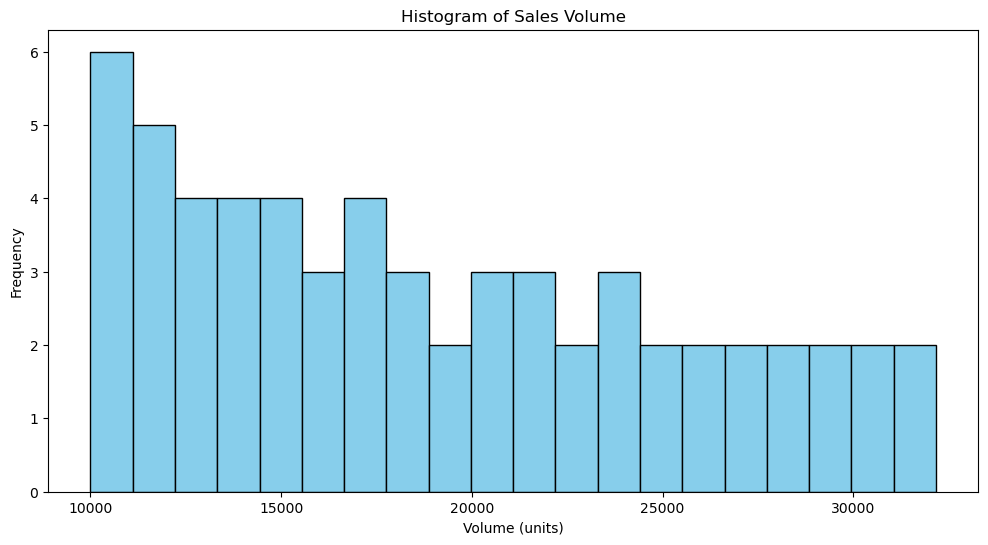

<Figure size 640x480 with 0 Axes>

In [91]:
# Histogram for sales volume
plt.figure(figsize=(12, 6))
plt.hist(df['Volume (units)'], bins=20, color='skyblue', edgecolor='black')
plt.title('Histogram of Sales Volume')
plt.xlabel('Volume (units)')
plt.ylabel('Frequency')
plt.show()

plt.savefig('histogram of sales volume.png')  # Save the plot as an image file


Insights from the plot:
- Since the histogram is skewed to the left (negative skew), it indicates that lower sales volumes are more common.
- Lower sales levels occur frequently than higher volume levels

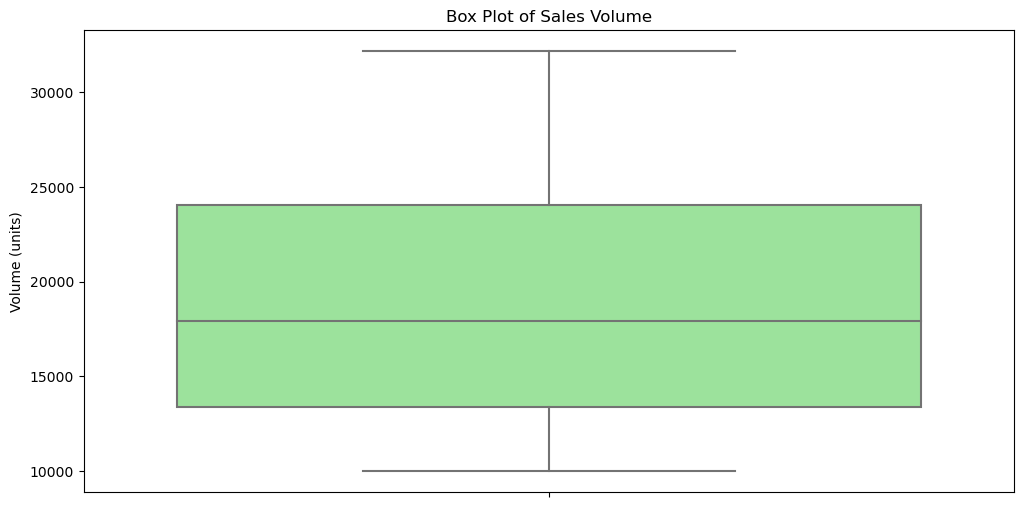

In [24]:
# Box Plot of Sales Volume
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, y='Volume (units)', color='lightgreen')
plt.title('Box Plot of Sales Volume')
plt.show()

Insights from the plot:
- There are no outlier values

<Figure size 1200x600 with 0 Axes>

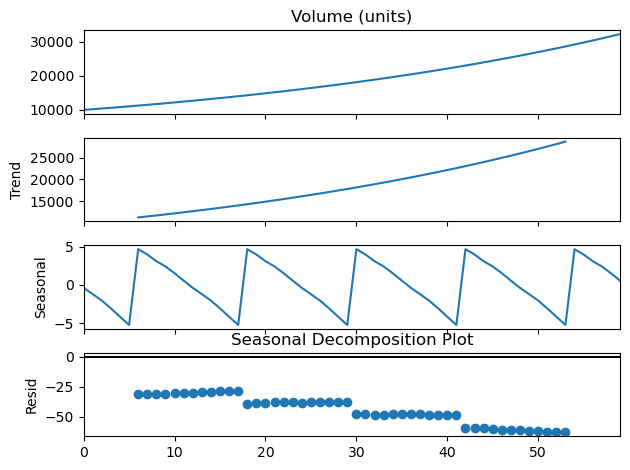

In [26]:
# Seasonal Decomposition Plot
plt.figure(figsize=(12, 6))
decomposition = seasonal_decompose(df['Volume (units)'], model='additive', period=12)
decomposition.plot()
plt.title('Seasonal Decomposition Plot')
plt.show()

# Save the plot as an image file
# plt.savefig('seasonal_decomposition_plot.png')

Insights from the plot:
- This plot suggests that the data has a slightly increasing trend with a seasonal component that repeats every after a certain period of time. 
- There is also some random variation in the data that is not explained by the trend or seasonality.

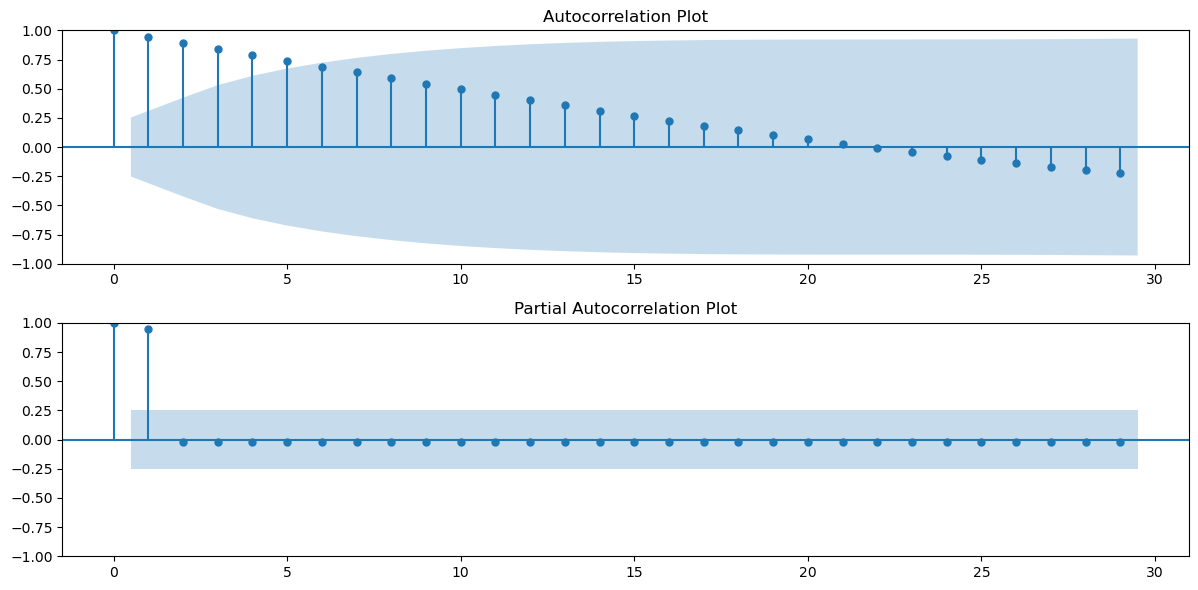

In [28]:
# Time Series Analysis
plt.figure(figsize=(12, 6))

# Autocorrelation Plot
plt.subplot(2, 1, 1)
plot_acf(df['Volume (units)'], lags=29, ax=plt.gca())
plt.title('Autocorrelation Plot')

# Partial Autocorrelation Plot
plt.subplot(2, 1, 2)
plot_pacf(df['Volume (units)'], lags=29, ax=plt.gca())
plt.title('Partial Autocorrelation Plot')

plt.tight_layout()
plt.show()

Insights from the plot:
- The autocorrelation plot shows some significant spikes at lags 0 and 10. This suggests that there may be periodic patterns in the data at these lags.
- The partial autocorrelation plot also shows a spike at lag 0, but not at lag 10. This suggests that there may be a periodic pattern at lag 0 that is independent of any shorter-term patterns

### Model Development (Training and Evaluation)
- Here I develop a model to forecast the sales volume for each month in 2023 using the historical sales data and apply time series forecasting technique known as ARIMA (AutoRegressive Integrated Moving Average) 

/Users/gabe/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/gabe/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabe/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabe/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/gabe/anaconda3/lib/python3.11/site-

Test RMSE: 1.319


/Users/gabe/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


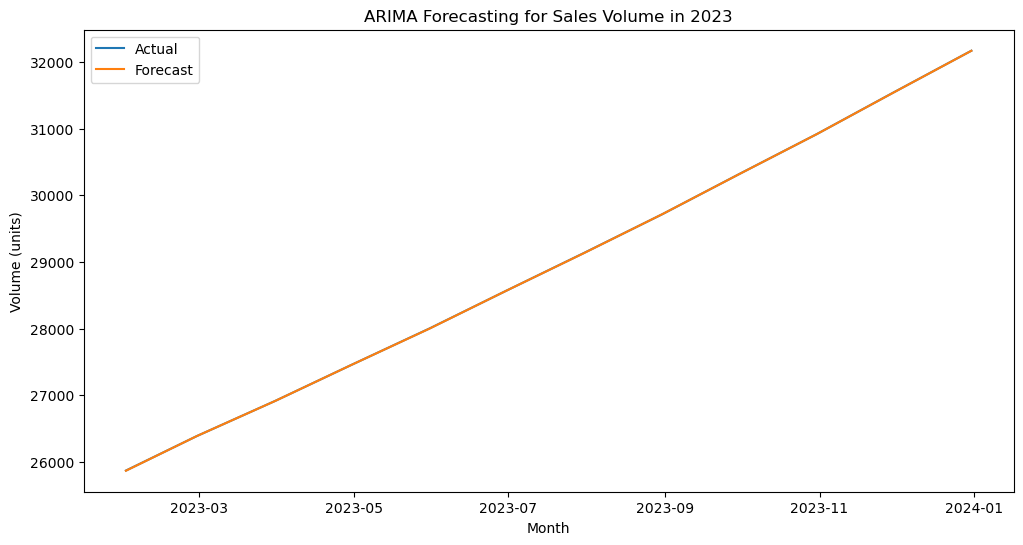

In [31]:
# Train-test split (80% train, 20% test)
train_size = int(len(df) * 0.8)
train, test = df.iloc[:train_size], df.iloc[train_size:]

# Define function to evaluate forecasts
def evaluate_forecasts(test, forecasts):
    mse = mean_squared_error(test, forecasts)
    rmse = np.sqrt(mse)
    return rmse

# Fit ARIMA model and make forecasts
history = train['Volume (units)'].tolist()
forecasts = []
for i in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    forecast = model_fit.forecast()[0]
    forecasts.append(forecast)
    history.append(test['Volume (units)'].iloc[i])

# Evaluate forecasts
rmse = evaluate_forecasts(test['Volume (units)'], forecasts)
print('Test RMSE: %.3f' % rmse)

# Plot forecasts vs. actual
plt.figure(figsize=(12, 6))
plt.plot(test['Month'], test['Volume (units)'], label='Actual')
plt.plot(test['Month'], forecasts, label='Forecast')
plt.title('ARIMA Forecasting for Sales Volume in 2023')
plt.xlabel('Month')
plt.ylabel('Volume (units)')
plt.legend()
plt.show()

In [32]:
# Create a DataFrame for actual and forecasted values
forecast_df = pd.DataFrame({'Month': test['Month'], 'Actual': test['Volume (units)'], 'Forecast': forecasts})

# Print the DataFrame
forecast_df

,Month,Actual,Forecast
48,2023-01-31,25871,25868.597892
49,2023-02-28,26388,26387.995420
50,2023-03-31,26916,26915.355852
51,2023-04-30,27454,27453.956165
52,2023-05-31,28003,28000.877676
53,2023-06-30,28563,28562.793593
54,2023-07-31,29135,29132.707476
55,2023-08-31,29717,29717.827498
56,2023-09-30,30312,30310.709529
57,2023-10-31,30918,30917.486831


In [33]:
forecast_df.reset_index(drop=True, inplace=True)

In [34]:
# Define profit margins for cash loans and product upgrades
profit_margin_cash_loan = 25  # Profit margin for cash loans ($)
profit_margin_product_upgrade = 150  # Profit margin for product upgrades ($)

# Define the decision variables
months = forecast_df["Month"]
cash_loans = [LpVariable(f"CashLoan_{month}", lowBound=0, cat="Integer") for month in months]
product_upgrades = [LpVariable(f"ProductUpgrade_{month}", lowBound=0, cat="Integer") for month in months]

# Initialize the optimization problem
prob = LpProblem("OptimalMix", LpMaximize)

# Define the objective function
prob += lpSum(cash_loans[i] * profit_margin_cash_loan + 
              product_upgrades[i] * profit_margin_product_upgrade for i in range(len(months)))

# Add constraints based on forecasted sales volume
for i, month in enumerate(months):
    prob += cash_loans[i] + product_upgrades[i] <= forecast_df["Forecast"][i]

# Solve the optimization problem
prob.solve()

# Display the optimal solution
print("Optimal Mix of Cash Loans and Product Upgrades:")
for i, month in enumerate(months):
    print(f"{month}: Cash Loans = {cash_loans[i].varValue}, Product Upgrades = {product_upgrades[i].varValue}")

# Calculate total profit
total_profit = sum(cash_loans[i].varValue * profit_margin_cash_loan + 
                   product_upgrades[i].varValue * profit_margin_product_upgrade for i in range(len(months)))
print(f"\nTotal Profit: ${total_profit}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/gabe/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/d3/kzqkcvc97h91sw6yv5lks0tw0000gp/T/4e0e6c4be5fb4ad181902bed7562b5dd-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/d3/kzqkcvc97h91sw6yv5lks0tw0000gp/T/4e0e6c4be5fb4ad181902bed7562b5dd-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 17 COLUMNS
At line 114 RHS
At line 127 BOUNDS
At line 152 ENDATA
Problem MODEL has 12 rows, 24 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5.20454e+07 - 0.00 seconds
Cgl0004I processed model has 12 rows, 24 columns (24 integer (0 of which binary)) and 24 elements
Cutoff increment increased from 1e-05 to 24.9999
Cbc0012I Integer solution of -52044150 found by DiveCoefficient after 0 iterations and 0 nodes (0.02 seco

In [70]:
import pandas as pd
import numpy as np

# Read sales data from CSV
sales_data = pd.read_csv("Data/data.csv")

# Define function to generate synthetic customer data
def generate_customer_data(sales_data):
    # Create DataFrame with customer purchase history
    customer_data = pd.DataFrame({
        'Date': pd.to_datetime(sales_data['Month']),
        'Classic Purchase': np.random.randint(2, size=len(sales_data)),  # Random purchase history
        'Loan Status': ['Paid' if np.random.rand() < 0.8 else 'Unpaid' for _ in range(len(sales_data))]  # Random loan status
    })
    
    return customer_data

# Generate synthetic customer data
customer_data = generate_customer_data(sales_data)

# Define eligibility criteria
cash_loan_eligibility = 0.9  # 90% of customers are eligible for a cash loan
vt_upgrade_eligibility_base = 0.57  # 57% of customers who haven't purchased any upsell loans are eligible for a VT upgrade
vt_upgrade_eligibility_decrease = 0.02  # Decreases by 0.02 for each cash loan purchased

# Determine Eligibility
customer_data['Cash Loan Eligible'] = np.where(np.random.rand(len(customer_data)) < cash_loan_eligibility, 1, 0)
customer_data['VT Upgrade Eligible'] = np.where(
    (customer_data['Classic Purchase'] == 0) & (customer_data['Cash Loan Eligible'] == 0) & 
    (np.random.rand(len(customer_data)) < vt_upgrade_eligibility_base - vt_upgrade_eligibility_decrease * customer_data['Cash Loan Eligible']), 
    1, 0)

# Calculate Loan and Upgrade Volumes
cash_loan_volume = customer_data['Cash Loan Eligible'].sum()
vt_upgrade_volume = customer_data['VT Upgrade Eligible'].sum()

# Profit Calculation
profit_margin_cash_loan = 25
profit_margin_vt_upgrade = 150
total_profit = cash_loan_volume * profit_margin_cash_loan + vt_upgrade_volume * profit_margin_vt_upgrade

# Display results
print("1) Number of cash loans and TV upgrades to be sold in 2023:")
print("   - Cash Loans:", cash_loan_volume)
print("   - TV Upgrades:", vt_upgrade_volume)
print("\n2) Total Profit under the optimal product mix: $", total_profit)

1) Number of cash loans and TV upgrades to be sold in 2023:
   - Cash Loans: 54
   - TV Upgrades: 0

2) Total Profit under the optimal product mix: $ 1350


/var/folders/d3/kzqkcvc97h91sw6yv5lks0tw0000gp/T/ipykernel_7930/457633748.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'Date': pd.to_datetime(sales_data['Month']),


In [80]:
import pandas as pd
import numpy as np

# Read sales data from CSV
sales_data = pd.read_csv("Data/data.csv")

# Define function to generate synthetic customer data
def generate_customer_data(sales_data):
    # Create DataFrame with customer purchase history
    customer_data = pd.DataFrame({
        'Date': pd.to_datetime(sales_data['Month']),
        'Classic Purchase': np.random.randint(2, size=len(sales_data)),  # Random purchase history
        'Loan Status': ['Paid' if np.random.rand() < 0.8 else 'Unpaid' for _ in range(len(sales_data))]  # Random loan status
    })
    
    return customer_data

# Generate synthetic customer data
customer_data = generate_customer_data(sales_data)

# Define eligibility criteria
cash_loan_eligibility = 0.9  # 90% of customers are eligible for a cash loan
vt_upgrade_eligibility_base = 0.57  # 57% of customers who haven't purchased any upsell loans are eligible for a VT upgrade
vt_upgrade_eligibility_decrease = 0.02  # Decreases by 0.02 for each cash loan purchased

# Determine Eligibility
customer_data['Cash Loan Eligible'] = np.where(np.random.rand(len(customer_data)) < cash_loan_eligibility, 1, 0)
customer_data['VT Upgrade Eligible'] = np.where(
    (customer_data['Classic Purchase'] == 0) & (customer_data['Cash Loan Eligible'] == 0) & 
    (np.random.rand(len(customer_data)) < vt_upgrade_eligibility_base - vt_upgrade_eligibility_decrease * customer_data['Cash Loan Eligible']), 
    1, 0)

# Calculate Loan and Upgrade Volumes
cash_loan_volume = customer_data['Cash Loan Eligible'].sum()
vt_upgrade_volume = customer_data['VT Upgrade Eligible'].sum()

# Profit Calculation
profit_margin_cash_loan = 25
profit_margin_vt_upgrade = 150
total_profit = cash_loan_volume * profit_margin_cash_loan + vt_upgrade_volume * profit_margin_vt_upgrade

# Display results
print("1) Number of cash loans and TV upgrades to be sold in 2023:")
print("   - Cash Loans:", cash_loan_volume)
print("   - TV Upgrades:", vt_upgrade_volume)
print("\n2) Total Profit under the optimal product mix: $", total_profit)

1) Number of cash loans and TV upgrades to be sold in 2023:
   - Cash Loans: 51
   - TV Upgrades: 3

2) Total Profit under the optimal product mix: $ 1725


/var/folders/d3/kzqkcvc97h91sw6yv5lks0tw0000gp/T/ipykernel_7930/457633748.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  'Date': pd.to_datetime(sales_data['Month']),


In [86]:
import pandas as pd
import numpy as np

# Read sales data from CSV
sales_data = pd.read_csv("Data/data.csv")

# Define function to generate synthetic customer data
def generate_customer_data(sales_data):
    # Create DataFrame with customer purchase history
    customer_data = pd.DataFrame({
        'Date': pd.to_datetime(sales_data['Month'], format='%Y-%m'),  # Specify date format
        'Classic Purchase': np.random.randint(2, size=len(sales_data)),  # Random purchase history
        'Loan Status': ['Paid' if np.random.rand() < 0.8 else 'Unpaid' for _ in range(len(sales_data))]  # Random loan status
    })
    
    return customer_data

# Generate synthetic customer data
customer_data = generate_customer_data(sales_data)

# Define eligibility criteria
cash_loan_eligibility = 0.9  # 90% of customers are eligible for a cash loan
vt_upgrade_eligibility_base = 0.57  # 57% of customers who haven't purchased any upsell loans are eligible for a VT upgrade
vt_upgrade_eligibility_decrease = 0.02  # Decreases by 0.02 for each cash loan purchased

# Group sales data by month and convert 'Volume (units)' to numeric data type
sales_data['Month'] = pd.to_datetime(sales_data['Month'], format='%Y-%m')  # Specify date format
monthly_sales = sales_data.groupby(pd.Grouper(key='Month', freq='M')).sum()

# Initialize lists to store results by month
cash_loans_by_month = []
vt_upgrades_by_month = []

# Iterate over each month in 2023
for month in pd.period_range(start='2023-01', end='2023-12', freq='M'):
    # Determine monthly sales volume
    monthly_sales_volume = monthly_sales.loc[month, 'Volume (units)']
    
    # Calculate eligible customers based on monthly sales volume
    eligible_customers = int(cash_loan_eligibility * monthly_sales_volume)
    
    # Calculate cash loans and TV upgrades based on eligibility criteria
    cash_loans = min(eligible_customers, monthly_sales_volume)  # No more cash loans than sales volume
    vt_upgrades = int((vt_upgrade_eligibility_base - vt_upgrade_eligibility_decrease * cash_loans) * monthly_sales_volume)
    
    # Append results to lists
    cash_loans_by_month.append(cash_loans)
    vt_upgrades_by_month.append(vt_upgrades)

# Display results
print("Number of cash loans and TV upgrades to be sold by month in 2023:")
for month, cash_loans, vt_upgrades in zip(pd.period_range(start='2023-01', end='2023-12', freq='M'), cash_loans_by_month, vt_upgrades_by_month):
    print(f"{month}: Cash Loans = {cash_loans}, TV Upgrades = {vt_upgrades}")

ValueError: time data "1/31/19" doesn't match format "%Y-%m", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [35]:
import pandas as pd
import numpy as np

# Generate synthetic data for 2023
months_2023 = pd.date_range(start='2023-01-01', end='2023-12-31', freq='M')

# Number of customers each month (assuming a constant number for simplicity)
num_customers_per_month = 1000

# Create a DataFrame to store the synthetic customer data
customer_datael = pd.DataFrame({'Month': np.repeat(months_2023, num_customers_per_month)})

# Assume that 90% of customers are eligible for a cash loan
cash_loan_eligibility_percentage = 0.9

# Check if customers have finished payment on their loans to determine cash loan eligibility
customer_datael['FinishedPayment'] = np.random.choice(['Yes', 'No'], size=len(customer_datael), p=[0.2, 0.8])
customer_datael['CashLoanEligible'] = (customer_datael['FinishedPayment'] == 'No') & (np.random.rand(len(customer_datael)) < cash_loan_eligibility_percentage)

# Determine eligibility for VT upgrades based on the number of upsell loans purchased
eligible_percentage_vt_upgrade = 57 - 0.2 * np.random.randint(0, 10, size=len(customer_datael))

# Apply the criteria provided to adjust eligibility for VT upgrades
customer_datael['UpsellLoans'] = np.random.randint(0, 5, size=len(customer_datael))  # Assuming a random number of upsell loans
customer_datael['VTUpgradeEligible'] = (customer_datael['UpsellLoans'] == 0) | ((np.random.rand(len(customer_datael)) * 100) <= eligible_percentage_vt_upgrade)

# Display the first few rows of the synthetic customer data
print(customer_datael.head())

       Month FinishedPayment  CashLoanEligible  UpsellLoans  VTUpgradeEligible
0 2023-01-31              No              True            1              False
1 2023-01-31              No              True            4               True
2 2023-01-31             Yes             False            3               True
3 2023-01-31              No              True            0               True
4 2023-01-31              No              True            3              False


In [36]:
import pandas as pd
import numpy as np

# Step 1: Generate Synthetic Customer Data
def generate_customer_data(num_customers):
    customer_data = pd.DataFrame({
        'CustomerID': np.arange(1, num_customers + 1),
        'PurchaseHistory': np.random.choice([0, 1], size=num_customers, p=[0.7, 0.3]),  # Binary purchase history
        'LoanStatus': np.random.choice(['Active', 'Paid'], size=num_customers, p=[0.8, 0.2])  # Loan status
    })
    return customer_data

# Step 2: Determine Eligibility
def determine_eligibility(customer_data):
    # Define eligibility criteria based on the provided information
    eligible_for_cash_loan = (customer_data['PurchaseHistory'] == 1) & (customer_data['LoanStatus'] == 'Active')
    eligible_for_vt_upgrade = (customer_data['PurchaseHistory'] == 0) & (customer_data['LoanStatus'] == 'Active')
    
    # Mark eligible customers in the DataFrame
    customer_data['EligibleForCashLoan'] = eligible_for_cash_loan
    customer_data['EligibleForVTUpgrade'] = eligible_for_vt_upgrade
    
    return customer_data

# Generate synthetic customer data
num_customers = 1000
customer_data = generate_customer_data(num_customers)

# Determine eligibility
customer_data = determine_eligibility(customer_data)

# Display the first few rows of the customer data with eligibility status
print(customer_data.head())


   CustomerID  PurchaseHistory LoanStatus  EligibleForCashLoan  \
0           1                0     Active                False   
1           2                1       Paid                False   
2           3                1       Paid                False   
3           4                0     Active                False   
4           5                1     Active                 True   

   EligibleForVTUpgrade  
0                  True  
1                 False  
2                 False  
3                  True  
4                 False  


In [37]:
# Step 2: Calculate Loan and Upgrade Volumes for 2023
def calculate_loan_upgrade_volumes(customer_data):
    # Assuming constant sales volume for simplicity
    total_customers = len(customer_data)
    cash_loan_customers = customer_data['EligibleForCashLoan'].sum()
    vt_upgrade_customers = customer_data['EligibleForVTUpgrade'].sum()

    # Calculate monthly volumes based on the total number of customers
    num_months = 12
    cash_loans_per_month = cash_loan_customers / num_months
    vt_upgrades_per_month = vt_upgrade_customers / num_months

    return cash_loans_per_month, vt_upgrades_per_month

# Step 3: Profit Calculation
def calculate_profit(cash_loans_per_month, vt_upgrades_per_month, profit_margin_cash_loan, profit_margin_vt_upgrade):
    # Assuming constant profit margins for simplicity
    total_cash_loan_profit = cash_loans_per_month * profit_margin_cash_loan * 12
    total_vt_upgrade_profit = vt_upgrades_per_month * profit_margin_vt_upgrade * 12

    total_profit = total_cash_loan_profit + total_vt_upgrade_profit
    return total_profit

# Step 4: Adjust Business Rules (Not implemented in code, suggestions can be provided based on analysis)
def adjust_business_rules():
    # Potential adjustments to improve profitability
    # Example: Adjust eligibility criteria, loan durations, profit margins, etc.
    pass

# Step 5: Operational Improvements (Not implemented in code, suggestions can be provided based on analysis)
def operational_improvements():
    # Potential operational improvements to enhance profitability
    # Example: Optimize sales strategies, refine pricing models, target specific customer segments, etc.
    pass

# Calculate Loan and Upgrade Volumes for 2023
cash_loans_per_month, vt_upgrades_per_month = calculate_loan_upgrade_volumes(customer_data)
print("Loan and Upgrade Volumes for 2023:")
print("Cash Loans per Month:", cash_loans_per_month)
print("VT Upgrades per Month:", vt_upgrades_per_month)

# Step 3: Profit Calculation
profit_margin_cash_loan = 25  # Profit margin for cash loans ($)
profit_margin_vt_upgrade = 150  # Profit margin for VT upgrades ($)
total_profit = calculate_profit(cash_loans_per_month, vt_upgrades_per_month, profit_margin_cash_loan, profit_margin_vt_upgrade)
print("\nTotal Profit from Cash Loans and TV Upgrades in 2023:", total_profit)

# Step 4: Adjust Business Rules (Potential adjustments to improve profitability)
adjust_business_rules()

# Step 5: Operational Improvements (Potential operational improvements to enhance profitability)
operational_improvements()

Loan and Upgrade Volumes for 2023:
Cash Loans per Month: 19.083333333333332
VT Upgrades per Month: 46.583333333333336

Total Profit from Cash Loans and TV Upgrades in 2023: 89575.0


In [38]:
# Assume that 90% of customers are eligible for a cash loan
cash_loan_eligibility_percentage = 0.9

# Check if customers have finished payment on their loans to determine cash loan eligibility
# Assuming 'FinishedPayment' column indicates whether the payment is finished or not
# Let's assume a DataFrame named 'customer_data' contains the necessary information

# Create a new column 'CashLoanEligible' to indicate cash loan eligibility
customer_datael['CashLoanEligible'] = (customer_datael['FinishedPayment'] == 'No') & (np.random.rand(len(customer_datael)) < cash_loan_eligibility_percentage)

# Determine eligibility for VT upgrades based on the number of upsell loans purchased
# Assuming 'UpsellLoans' column indicates the number of upsell loans purchased
# Let's assume a DataFrame named 'customer_data' contains the necessary information

# Determine eligibility percentage for VT upgrades based on the number of upsell loans
eligible_percentage_vt_upgrade = 57 - 0.2 * customer_datael['UpsellLoans']

# Apply the criteria provided to adjust eligibility for VT upgrades
# Create a new column 'VTUpgradeEligible' to indicate VT upgrade eligibility
customer_datael['VTUpgradeEligible'] = (customer_datael['UpsellLoans'] == 0) | ((np.random.rand(len(customer_datael)) * 100) <= eligible_percentage_vt_upgrade)


In [39]:
customer_datael

,Month,FinishedPayment,CashLoanEligible,UpsellLoans,VTUpgradeEligible
0,2023-01-31,No,True,1,True
1,2023-01-31,No,True,4,True
2,2023-01-31,Yes,False,3,True
3,2023-01-31,No,True,0,True
4,2023-01-31,No,True,3,True
...,...,...,...,...,...
11995,2023-12-31,Yes,False,1,True
11996,2023-12-31,No,True,3,True
11997,2023-12-31,No,True,2,False
11998,2023-12-31,No,True,4,False


In [40]:
import pandas as pd
from pulp import LpProblem, LpMaximize, LpVariable, lpSum

# Step 1: Determining Optimal Mix of Cash Loans and Product Upgrades
def determine_optimal_mix(forecast_df, profit_margin_cash_loan, profit_margin_product_upgrade):
    # Define decision variables
    months = forecast_df.index
    cash_loans = {month: LpVariable(f"CashLoan_{month}", lowBound=0, cat="Integer") for month in months}
    product_upgrades = {month: LpVariable(f"ProductUpgrade_{month}", lowBound=0, cat="Integer") for month in months}

    # Initialize optimization problem
    prob = LpProblem("OptimalMix", LpMaximize)

    # Define objective function
    prob += lpSum(cash_loans[month] * profit_margin_cash_loan + 
                  product_upgrades[month] * profit_margin_product_upgrade for month in months)

    # Add constraints based on forecasted sales volume
    for month in months:
        prob += cash_loans[month] + product_upgrades[month] <= forecast_df.loc[month, 'Forecast']

    # Solve the optimization problem
    prob.solve()

    # Return optimal mix
    optimal_mix = {month: (cash_loans[month].varValue, product_upgrades[month].varValue) for month in months}
    return optimal_mix

# Step 2: Profit Calculation
def calculate_profit(optimal_mix, profit_margin_cash_loan, profit_margin_product_upgrade):
    total_profit = sum(cash_loans * profit_margin_cash_loan + 
                       product_upgrades * profit_margin_product_upgrade 
                       for cash_loans, product_upgrades in optimal_mix.values())
    return total_profit



# Set profit margins
profit_margin_cash_loan = 25  # Profit margin for cash loans ($)
profit_margin_product_upgrade = 150  # Profit margin for product upgrades ($)

# Determine optimal mix
optimal_mix = determine_optimal_mix(forecast_df, profit_margin_cash_loan, profit_margin_product_upgrade)
print("Optimal Mix of Cash Loans and Product Upgrades:")
for month, (cash_loans, product_upgrades) in optimal_mix.items():
    print(f"{month}: Cash Loans = {cash_loans}, Product Upgrades = {product_upgrades}")

# Calculate total profit
total_profit = calculate_profit(optimal_mix, profit_margin_cash_loan, profit_margin_product_upgrade)
print(f"\nTotal Profit: ${total_profit}")

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /Users/gabe/anaconda3/lib/python3.11/site-packages/pulp/solverdir/cbc/osx/64/cbc /var/folders/d3/kzqkcvc97h91sw6yv5lks0tw0000gp/T/f21f4208253c48f194442d7a6cc65923-pulp.mps -max -timeMode elapsed -branch -printingOptions all -solution /var/folders/d3/kzqkcvc97h91sw6yv5lks0tw0000gp/T/f21f4208253c48f194442d7a6cc65923-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 17 COLUMNS
At line 114 RHS
At line 127 BOUNDS
At line 152 ENDATA
Problem MODEL has 12 rows, 24 columns and 24 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 5.20454e+07 - 0.00 seconds
Cgl0004I processed model has 12 rows, 24 columns (24 integer (0 of which binary)) and 24 elements
Cutoff increment increased from 1e-05 to 24.9999
Cbc0012I Integer solution of -52044150 found by DiveCoefficient after 0 iterations and 0 nodes (0.00 seco

# Question 3: Potential adjustments to business rules to improve profitability

        "Adjust eligibility criteria for cash loans and VT upgrades based on customer behavior or demographics",
        "Introduce promotional offers or discounts to encourage more customers to opt for upgrades",
        "Optimize pricing strategies to maximize profitability while remaining competitive",
        "Explore partnerships or collaborations to offer additional value-added services to customers",
        "Implement targeted marketing campaigns to reach specific customer segments more effectively"


# Question 4: Operational improvements to investigate to improve profitability

        "Enhance customer experience and satisfaction to increase repeat purchases and customer loyalty",
        "Streamline internal processes and workflows to reduce costs and improve efficiency",
        "Invest in technology infrastructure and analytics capabilities to better understand customer behavior and preferences",
        "Train and develop sales teams to effectively promote and sell cash loans and VT upgrades",
        "Monitor and analyze market trends and competitor activities to identify new opportunities for growth"
